# Christmas demo: how to decorate your Christmas tree

Decorating a Christmas tree can be a challenge! Let's see how optmization can help for this problem.

In [1]:
# Import the relevant library
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib.colors import LinearSegmentedColormap
from naginterfaces.base import utils
from naginterfaces.library import opt
from naginterfaces.library import mip

## 1. Defining the tree 
We have to start by defining the tree as the domain on which we want to optimize the function.

Let's start by defining some christmasy colour scheme: 

In [2]:
cdict_green = {'red': ((0, 0, 0),
                 (1, 0, 0)),
         'green': ((0, 0, 0),
                   (1, 1, 1)),
         'blue': ((0, 0, 0),
                  (1, 0, 0))}
cdict_red = {'red': ((0, 0.5, 0.5),
                 (1, 1, 1)),
         'green': ((0, 0, 0),
                   (1, 0, 0)),
         'blue': ((0, 0, 0),
                  (1, 0, 0))}
green_cm = LinearSegmentedColormap('green_cm', cdict_green)
red_cm = LinearSegmentedColormap('red_cm', cdict_red)

Then define some functions to help draw a 2-dimensions tree

In [3]:
def objf_plot(X,Y):
    return X**2 + X + np.cos(2*np.pi*Y)**2 + 0.5*Y

In [4]:
def plot_domain(orig,lb,ub,cm, axis, ax):
    xmax = orig - lb
    X, Y = np.meshgrid(np.arange(-xmax,xmax,0.01), np.arange(lb,orig,0.01))
    Z = objf_plot(X,Y)
    mask = np.zeros_like(Z, dtype=bool)
    row, col = X.shape
    for i in range(row):
        for j in range(col):
            if X[i,j]>=0 and X[i,j]+Y[i,j]>orig:
                mask[i,j] = 1
            elif X[i,j]<=0 and Y[i,j]-X[i,j]>orig:
                mask[i,j] = 1
            elif Y[i,j] > ub:
                mask[i,j] = 1
            else:
                mask[i,j] = 0
    Z = np.ma.array(Z, mask=mask)
    ax.axis(axis)
    ax.contourf(X, Y, Z, cmap=green_cm, corner_mask=True)

Let's see the result:

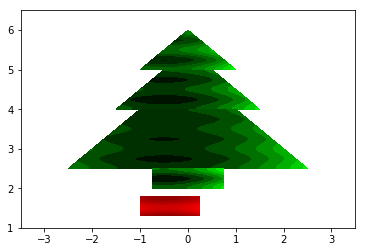

In [5]:
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(111)
axis = [-3.5, 3.5, 1, 6.5]
# main tree
plot_domain(5.5, 4, 5, green_cm, axis, ax)
plot_domain(6, 5, 999, green_cm, axis, ax)
plot_domain(5, 2.5, 4, green_cm, axis, ax)
# trunk
X, Y = np.meshgrid(np.arange(-0.75,0.75,0.01), np.arange(2,2.5,0.01))
Z = objf_plot(X,Y)
ax.contourf(X, Y, Z, cmap=green_cm)
# present
X, Y = np.meshgrid(np.arange(-1.,0.25,0.01), np.arange(1.3,1.8,0.01))
Z = objf_plot(X,Y)
ax.contourf(X, Y, Z, cmap=red_cm)
plt.show()

Finding the minimum value on the tree is not trivial at first sight:
1. the domain is disjointed
2. each sub-part of the tree follows linear constraints, but there is no straightforward way to merge the different parts in a single set of constraints.

## 2. Splitting the domain

### A simple division first
A solution would be to look at the different parts of the tree separately. For example, if we want the minimum on the top of the tree we have a domain that is defined by three linear constraints:

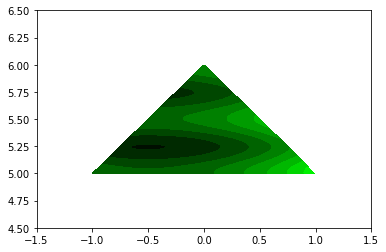

In [6]:
orig = 6
lb = 5
ub = 999
axis = [-1.5, 1.5, 4.5, 6.5]
fig = plt.figure()
ax = fig.add_subplot(111)
plot_domain(orig, lb, ub, green_cm, axis, ax)
plt.show()

Optimizing on this part should be easy: let's use one of NAG's nonlinear programming solver.

In [7]:
# define the user structure that will be passed by the solver to the different callbacks functions
# we use it here to record the points evaluated by the solver 
class usr_data:
    def __init__(self):
        self.npts = 0
        self.pts = []
        self.present = False

In [8]:
# main callback function for the SQP solver
def objfun_e04wd(mode, x, grad, ntsate, data):
    if mode == 0 or mode == 2:
        objf = x[0]**2 + x[0] + np.cos(2*np.pi*x[1])**2 + 0.5*x[1]
        data.npts += 1
        data.pts.append((x[0], x[1]))
    if mode == 1 or mode == 2:
        grad[0] = 2*x[0] + 1
        grad[1] = -4*np.pi*np.sin(2*np.pi*x[1])*np.cos(2*np.pi*x[1]) + 0.5
    return mode, objf, grad

In [9]:
# Define the model: The domain is limited by 2 linear constraints and one bound constraint
bigbnd = 1.0e20
n = 2
nclin = 2
ncnln = 0
a = [[1.,1.],[-1.,1.]]
bl = [-bigbnd,5,-bigbnd,-bigbnd]
bu = [bigbnd,bigbnd,6,6];

# Initialize the rest of the solver variables: we don't need warm starting information or 2nd derivative information
istate = [0,0,0,0]
ccon = np.zeros(1)
cjac = np.zeros((0,1))
clamda = np.zeros(n+nclin+ncnln)
h = np.zeros((2,2))
iom = utils.FileObjManager(locus_in_output=False)

# Define a starting point and initialize the user data
xstart1 = [0.,6.]
x = xstart1
comm = opt.nlp2_init(io_manager=iom)
data = usr_data()

# Solve the model, the solution and convergence measures will be stored in sln
sln = opt.nlp2_solve(a, bl, bu, objfun_e04wd, istate, ccon, cjac, clamda, h, x, comm, data=data, io_manager=iom)

We can now discover where the optimum is and start to decorate the top of the tree with the points the solver evaluated.

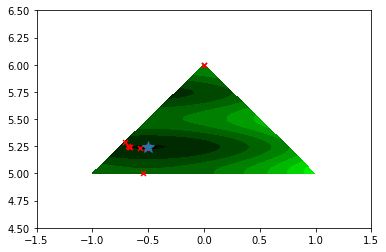

In [10]:
# plot the top of the trees as well as the histoy of the points evaluated
fig = plt.figure()
ax = fig.add_subplot(111)
plot_domain(orig, lb, ub, green_cm, axis, ax)
ax.plot(sln.x[0], sln.x[1], marker='*', markersize=12)
ax.scatter(*zip(*data.pts), s=25, marker='x', c='red')
plt.show()

### Joining two domains
If we now want to add the middle part of the tree, the domain definition becomes more complicated:

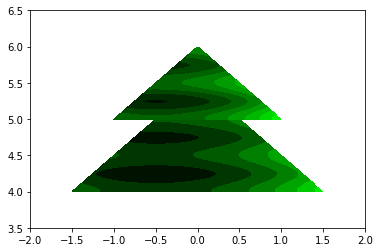

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111)
axis = [-2., 2., 3.5, 6.5]
plot_domain(5.5, 4, 5, green_cm, axis, ax)
plot_domain(6, 5, 999, green_cm, axis, ax)
plt.show()

It is possible to join both the middle and the top of the tree to the same model by introducing additional decision variables to the problem. The goal is to introduce a binary variable $\delta_K$ for each subdomain $K$ such that $\delta_K=1 \Rightarrow (x,y) \in K$. In general, for a constraint of the form $ax+by \leq c$, it is possible to create such a decision variable $\delta$ by replacing the original inequality by: $$ax+by+M\delta \leq M + c$$ where $M$ is an upper bound on the quantity $ax+by-c$. You then have a constraint where if $\delta=1$, the original inequality applies, and if $\delta=0$, the inequality becomes $ax+by-c \leq M$ which is always satisfied so has no influence.

As each of the subdomain is defined by three linear inequalities, we can apply this technique to all of our constraints and introduce two binary variables $\delta_{top}$ and $\delta_{mid} \in \{0,1\}$. The model can then be written as:
$$
\begin{equation*}
\min_{(x,y)\in \mathbb{R}^n} F(x,y)\\
\text{s.t. } \left\{ \begin{aligned} x + y + \delta_{top}M &\leq M + 6\\
-x + y + \delta_{top}M &\leq M + 6\\ y - \delta_{top}M &\geq -M + 5\\
x + y + \delta_{mid}M &\leq M + 5.5\\ -x + y + \delta_{mid}M &\leq M + 5.5\\
y - \delta_{mid}M &\geq -M + 4\\ 
\end{aligned}\right. 
\end{equation*}
$$
For simplicity we chose a unique $M=9$ which works as a bound for all of these inequalities.

As it stands, the model is still incomplete. The solver could indeed choose $\delta_{mid}=\delta_{top}=0$ and ignore all constraints. To force the model to choose a point that is in at least one of the domains, we need to add a binding constraint: 
$$ \delta_{mid}+\delta_{top} \geq 1 $$
specifying that at least one of the sets of constraints has to be satisfied.

As the model now involves binary variables, a classical NLP solver is no longer suitable. We solved this model with NAG's MINLP solver mip.sqp (h02da).

In [12]:
# Main callback function for the MINLP solver
def objfun_h02da(mode, varcon, x, objgrd, nstate, data):
    objmip = x[0]**2 + x[0] + np.cos(2*np.pi*x[1])**2 + 0.5*x[1];
    data.npts = data.npts + 1;
    data.pts.append((x[0], x[1]))
    if x[1] <= 1.8 and data.present:
        objmip = (x[0]+0.625)**2 + (x[1]-1.55)**2

    if mode == 1:
        objgrd[0] = 2*x[0] + 1
        objgrd[1] = -4*np.pi*np.sin(2*np.pi*x[1])*np.cos(2*np.pi*x[1]) + 0.5
        if x[1] <= 1.8 and data.present:
            objgrd[0] = 2*(x[0]+0.625)
            objgrd[1] = 2*(x[1]-1.55)
    return objmip, objgrd

In [13]:
# Define the model
ncnln = 0
M = 9.
a =  np.array([[0.,0.,1.,1.],
      [1.,-1.,-M,0.],
      [-1.,-1.,-M,0.],
      [0.,1.,-M,0.],
      [1.,-1.,0.,-M],
      [-1.,-1.,0.,-M],
      [0.,1.,0.,-M]])
d = [1.,-6.-M,-6.-M,-M+5.,-M-5.5,-M-5.5,-M+4.]
bl = [-5.,-2.,0.,0.]
bu = [5.,10.,1.,1.]
varcon = [0,0,1,1,4,4,4,4,4,4,4]

# Choose a starting point and initialize the solver and user data
xstart = [0.5,4.5,0.,0.];
x = xstart
comm = {}
data = usr_data()
mip.optset('Initialize = sqp', comm)

# Solve the model

sln = mip.sqp(ncnln, bl, bu, varcon, x, objfun_h02da, comm, a = a,d=d, maxit=500, acc=0.0001, data=data, io_manager=iom)

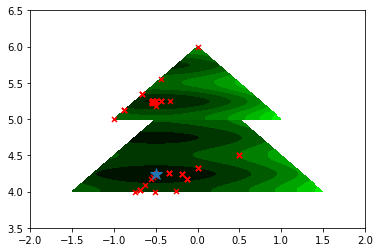

In [14]:
# Plot the domain and add the evealuated points 
fig = plt.figure()
ax = fig.add_subplot(111)
plot_domain(5.5, 4, 5, green_cm, axis, ax)
plot_domain(6, 5, 999, green_cm, axis, ax)
ax.plot(sln.x[0], sln.x[1], marker='*', markersize=12)
ax.scatter(*zip(*data.pts), s=25, marker='x', c='red')
plt.show()

### Full model
We can now consider the full model by using the same tricks with more disjointed sub-domains:
$$
\begin{equation*}
\min_{(x,y)\in \mathbb{R}^n} F(x,y)\\
\text{s.t. } \left\{ \begin{aligned} \left.
\delta_{top} + \delta_{mid} + \delta_{bot} + \delta_{tr} + \delta_{pr} \geq 1 \right\}\text{binding constraint}\\
\left.\begin{aligned} x + y + \delta_{top}M &\leq M + 6\\
-x + y + \delta_{top}M &\leq M + 6\\
y - \delta_{top}M &\geq -M + 5\\
\end{aligned}\right\}\text{top of the tree}\\
\left.\begin{aligned} x + y + \delta_{mid}M &\leq M + 5.5\\
-x + y + \delta_{mid}M &\leq M + 5.5\\
y - \delta_{mid}M &\geq -M + 4\\
\end{aligned}\right\}\text{middle of the tree}\\
\left.\begin{aligned} x + y + \delta_{bot}M &\leq M + 5\\ 
-x + y + \delta_{bot}M &\leq M + 5\\ y - \delta_{bot}M &\geq -M + 2.5\\
\end{aligned}\right\}\text{bottom of the tree}\\
\left.\begin{aligned} x - \delta_{tr}M &\geq -M - 0.75\\ 
x + \delta_{tr}M &\leq M + 0.75\\
y - \delta_{tr}M &\geq -M + 2\\
y + \delta_{tr}M &\leq M + 2.5\\ 
\end{aligned}\right\}\text{trunk}\\ 
\left.\begin{aligned} x - \delta_{pr}M &\geq -M - 1\\
x + \delta_{pr}M &\leq M - 0.25\\ 
y - \delta_{pr}M &\geq -M + 1.8\\ 
y + \delta_{pr}M &\leq M + 1.3\\
\end{aligned}\right\}\text{present}\\
\end{aligned}\right. 
\end{equation*}
$$

It is still important to note that this is a local solver and that it could declare convergence at any of the local minima in the domain depending on the starting point.

In [15]:
# Extend the model 
row, col = a.shape
a2 = np.zeros((row, col+3))
a2[:,:-3] = a
a2[0,4:6] = 1.
add_rows = [[1.,-1.,0.,0.,-M,0.,0.],
            [-1.,-1.,0.,0.,-M,0.,0.],
            [0.,1.,0.,0.,-M,0.,0.],
            [0.,1.,0.,0.,0.,-M,0.],
            [0.,-1.,0.,0.,0.,-M,0.],
            [1.,0.,0.,0.,0.,-M,0.],
            [-1.,0.,0.,0.,0.,-M,0.],
            [0.,1.,0.,0.,0.,0.,-M],
            [0.,-1.,0.,0.,0.,0.,-M],
            [1.,0.,0.,0.,0.,0.,-M],
            [-1.,0.,0.,0.,0.,0.,-M]]
a2 = np.vstack((a2, add_rows))
d.extend([-M-5,-M-5,-M+2.5])
d.extend([-M+2,-M-2.5,-M-0.75,-M-0.75])
d.extend([-M+1.3,-M-1.8,-M-1,-M+0.25])
bl.extend([0.,0.,0.])
bu.extend([0.,0.,0.])

In [16]:
# Optimize the model
xstart = [1.,2.5,0.,0.,1.,0.,0.]
x = xstart
varcon = [0,0,1,1,1,1,1,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4]
comm = {}
data = usr_data()
mip.optset('Initialize = sqp', comm)
sln = mip.sqp(ncnln, bl, bu, varcon, x, objfun_h02da, comm, a=a2,d=d,maxit=500, acc=0.0001, data=data,
              io_manager=iom)

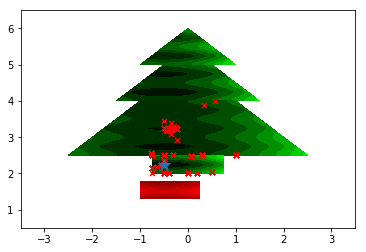

In [17]:
# Plot the tree and the points evaluated
fig = plt.figure()
ax = fig.add_subplot(111)
axis = [-3.5, 3.5, 0.5, 6.5]
# main tree
plot_domain(5.5, 4, 5, green_cm, axis, ax)
plot_domain(6, 5, 999, green_cm, axis, ax)
plot_domain(5, 2.5, 4, green_cm, axis, ax)
# trunk
X, Y = np.meshgrid(np.arange(-0.75,0.75,0.01), np.arange(2,2.5,0.01))
Z = objf_plot(X,Y)
ax.contourf(X, Y, Z, cmap=green_cm)
# present
X, Y = np.meshgrid(np.arange(-1.,0.25,0.01), np.arange(1.3,1.8,0.01))
Z = objf_plot(X,Y)
ax.contourf(X, Y, Z, cmap=red_cm)
ax.plot(sln.x[0], sln.x[1], marker='*', markersize=12)
ax.scatter(*zip(*data.pts), s=25, marker='x', c='red')
plt.show()